### Marketing analysis
Import all necessary dependences

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, ConfusionMatrixDisplay


from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from scipy import stats
import statsmodels.stats.power as power

from imblearn.pipeline import Pipeline as Pipe
from itertools import combinations
from imblearn.combine import SMOTETomek

from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import category_encoders as ce
import shap
!pip install -q BorutaShap
from BorutaShap import BorutaShap

seed = 123
np.random.seed(seed)
clear_output()

In [2]:
path = r'marketing_campaign.csv'
TARGET_NAME = 'Response'

In [3]:
df = pd.read_csv(path, sep='\t')
df.sample(5).transpose()

,1376,1440,905,1353,406
ID,1542,5967,11074,5232,3645
Year_Birth,1975,1952,1977,1965,1972
Education,Graduation,Graduation,Graduation,Graduation,PhD
Marital_Status,Single,Together,Single,Married,Single
Income,56243.0,33402.0,85072.0,69139.0,27213.0
Kidhome,1,1,0,0,1
Teenhome,2,1,0,1,0
Dt_Customer,30-12-2013,18-07-2013,09-04-2014,27-01-2014,30-08-2012
Recency,26,60,94,23,19
MntWines,347,26,494,86,19


In [4]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def reduce_memory(df, verbose=0):
    if verbose != 0:
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    if verbose != 0:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def roc_plot(y_true, probs):
    fpr, tpr, threshold = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def cross_validation(clf, X, y, scoring='f1'):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def effect_size(factor_a, factor_b, cohen=True, desired_power=0.8, alpha=0.05):
    n1, n2 = len(factor_a), len(factor_b)
    s1, s2 = factor_a.std(ddof=1), factor_b.std(ddof=1)
    df = (s1 ** 2 / n1 + s2 ** 2 / n2) ** 2 / \
          ((s1 ** 2 / n1) ** 2 / (n1 - 1) + (s2 ** 2 / n2) ** 2 / (n2 - 1))
    if cohen:
        sigma_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
        return np.abs(factor_a.mean() - factor_b.mean()) / sigma_pooled, df
    else:
        return power.tt_ind_solve_power(effect_size=None, nobs1=len(factor_a), alpha=alpha, power=desired_power,
                                        ratio=len(factor_b)/len(factor_a), alternative='two-sided'), df
    
def statistic_output(*columns, df=df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', 'object']).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=seed)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical impact on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    try:
                        data_ = data.loc[data[column].isin(pair), ['ID', column, target]].sample(sample_size, random_state=seed)
                    except ValueError:
                        continue
                    table = data_.pivot_table(values='ID', index=column, columns=target, aggfunc='count')
                    try:
                        _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    except ValueError:
                        continue
                    if pvalue >= alpha:
                        print(f'Categories {a} and {b} can be united. P-value: {pvalue:.6f}')
                    else:
                        pass
                        #print(f'Categories {a} and {b} have different frequencies with target.')
                        
def categorical_stats(df=df, target=TARGET_NAME, alpha=0.05, sample_size=500):
    data = df.copy().sample(sample_size)
    columns_to_analize = data.select_dtypes(include=['category', 'object']).columns
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[TARGET_NAME])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature {factor} has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)

In [5]:
df.info()
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
df.describe().transpose()
# max income = 666666 looks like outliers
# MntMeatProducts, MntWines - check if there are outliers
# Z_CostContact, Z_Revenue look like constant features

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


In [7]:
df.describe(include=['object'])
# Dt_Customer - we will transform it
# others: check if we can unite categories
# cardinality of others is low, we may apply one-hot encoding 

,Education,Marital_Status,Dt_Customer
count,2240,2240,2240
unique,5,8,663
top,Graduation,Married,31-08-2012
freq,1127,864,12


In [8]:
df[TARGET_NAME].value_counts(normalize=True)
# pretty high imbalance, we will apply class weights, sampling techniques

0    0.850893
1    0.149107
Name: Response, dtype: float64

In [9]:
Z_Cost = df.loc[df['Z_CostContact'] != 3.0, 'Z_CostContact'].sum()
print(f"Z_CostContact is {'not' if Z_Cost > 0 else ''}constant feature")
Z_Rev = df.loc[df['Z_Revenue'] != 11.0, 'Z_Revenue'].sum()
print(f"Z_Revenue is {'not' if Z_Rev > 0 else ''}constant feature")
if Z_Cost == 0:
    df.drop('Z_CostContact', axis=1, inplace=True)
if Z_Rev == 0:
    df.drop('Z_Revenue', axis=1, inplace=True)

Z_CostContact is constant feature
Z_Revenue is constant feature


#### Visualizations

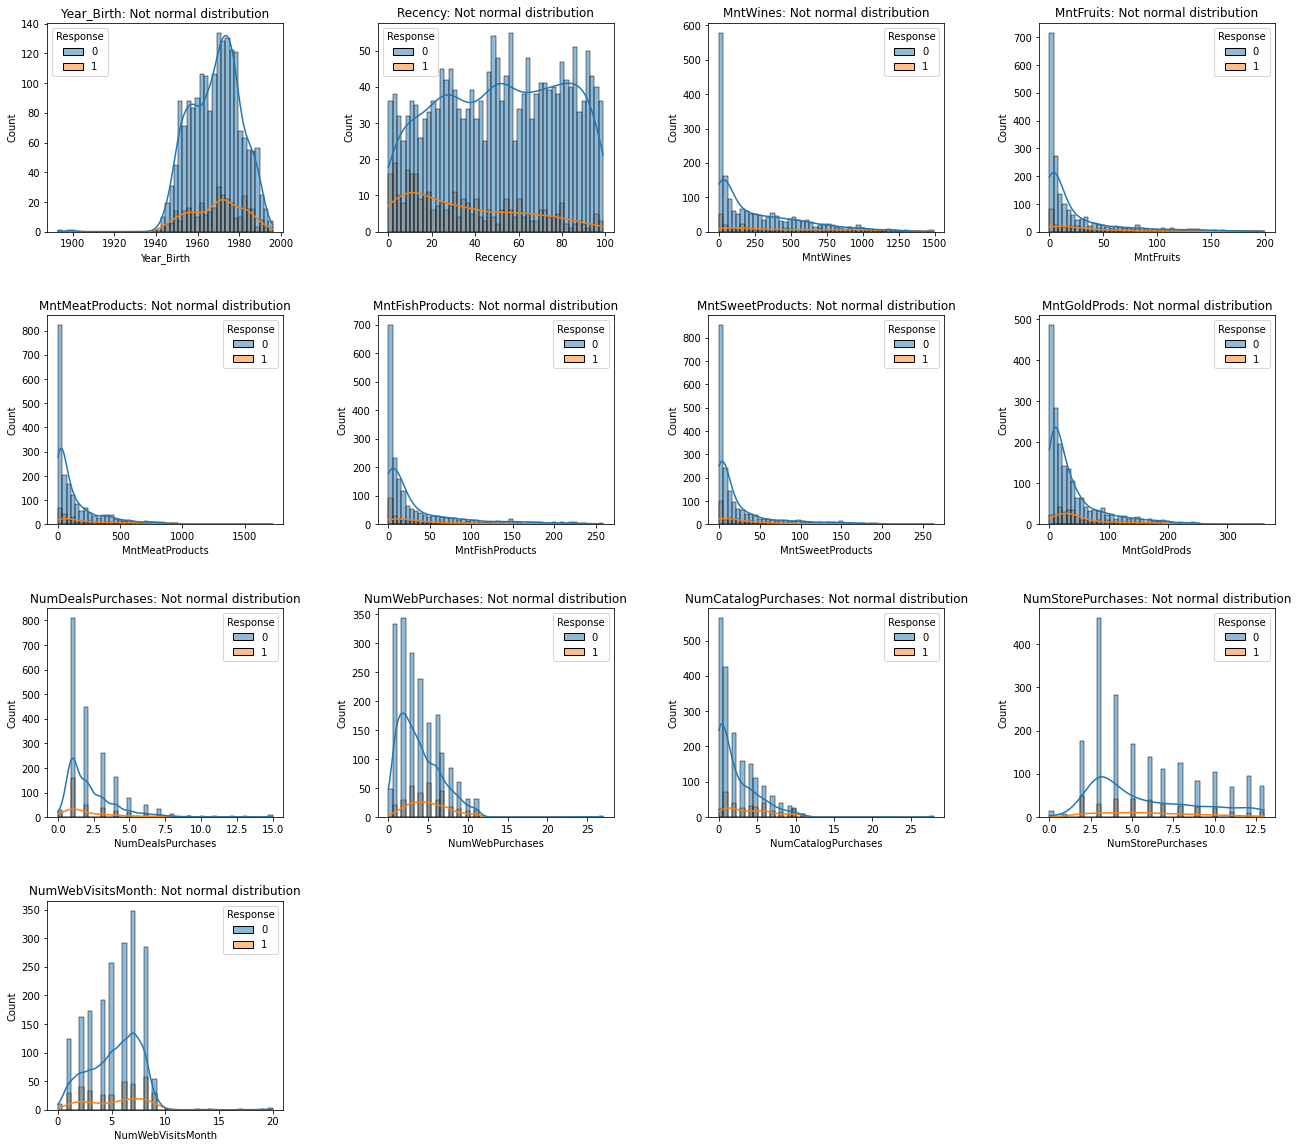

In [10]:
numerical_cols = df.drop(['ID'], axis=1).select_dtypes(include=[np.int64]).columns.tolist()
numerical_cols = [column for column in numerical_cols if not column[:3] in ['Acc', 'Res', 'Tee', 'Kid', 'Com']]

plt.figure(figsize=(22, 20))
for idx, column in enumerate(numerical_cols):
    plt.subplot(4, 4, idx + 1)
    dist = 'Normal Distribution' if stats.shapiro(df[column].sample(100))[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
    sns.histplot(data=df, x=column, hue=TARGET_NAME, bins=50, kde=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# almost all num and mnt features are skewed
# features look like they may have impact on target
# maybe we have to deal with outliers - later

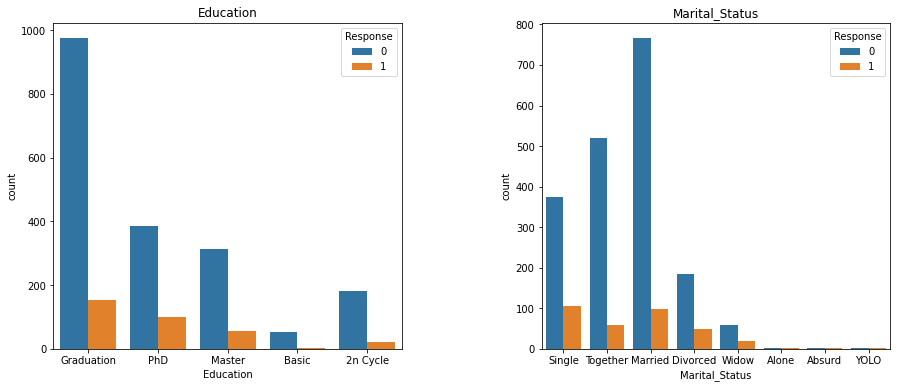

In [11]:
categorical_cols = df.drop('Dt_Customer', axis=1).select_dtypes(include=['object']).columns

plt.figure(figsize=(15, 6))
for idx, column in enumerate(categorical_cols, 1):
    plt.subplot(1, 2, idx)
    plt.title(f'{column}')
    sns.countplot(x=column, hue=TARGET_NAME, data=df)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()
# maybe we can unite some categories - let's make statistical tests later

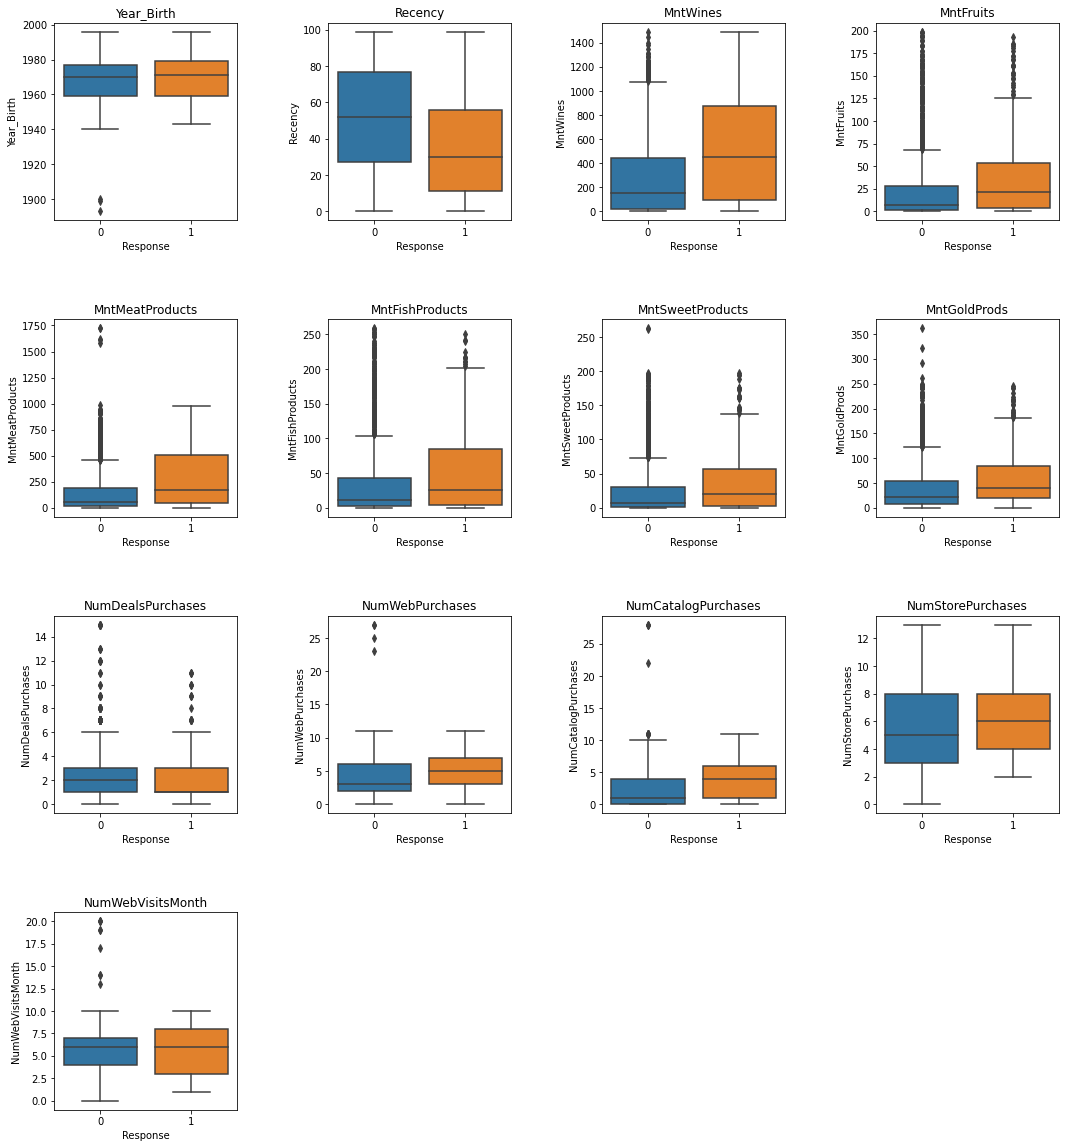

In [12]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=df[column], x=df[TARGET_NAME], data=df)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()
# some features may appear as not important (medians are equal in different classes)
# we have some outliers in here: drop (if there are few) or drop only significant (IsolationForest to find out wich ones)
# impute some significant outliers or let them stay. We will test on lgbm/logreg base model

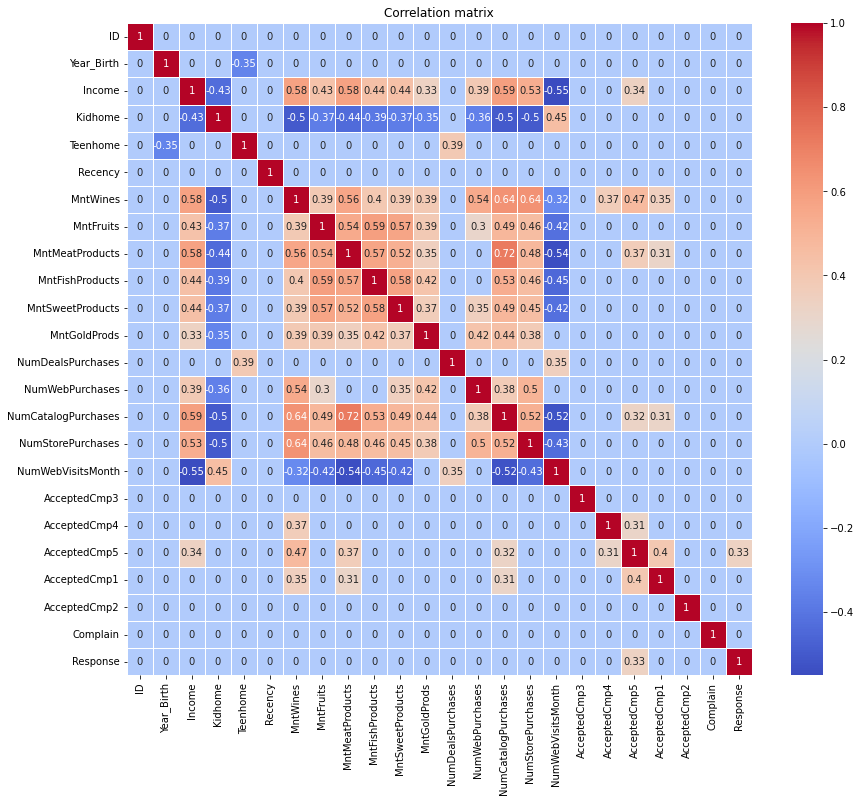

In [13]:
# let's see if there are any meaningful correlations
plt.figure(figsize = (14,12))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
# no extra high correlations, except meat products and number of catalog purchases
# lot's of medium high correlations between income and amount of money spent on different goods categories
# let the BestSet class decide if there is a need of dropping some features

#### Some early obvious transforms

In [14]:
# make Age feature out of year of birth
df['Age'] = 2022 - df['Year_Birth']
df.drop('Year_Birth', axis=1, inplace=True)

In [15]:
# transform date into number of days
df["Dt_Customer"] = pd.to_datetime('02-04-2022') - pd.to_datetime(df["Dt_Customer"])
df["Dt_Customer"] = df["Dt_Customer"].dt.days

In [16]:
df = df[df['Age'] < 90]
df = df[df['Income'] < 600000]
print(f'After removing outliers: {len(df)}')
# about removing other possible outliers we will decide later

After removing outliers: 2212


In [17]:
df.duplicated().sum()
# no duplicates

0

#### Some statistic tests

In [18]:
statistic_output(df=df.drop('Complain', axis=1), sample_size=200)
# as we can see lots of features are not important

Factor "ID" does not affect target.
Factor "Income" has statistical impact on target (var_a: 441370781.78, var_b: 593706214.65). 
Factor "Kidhome" does not affect target.
Factor "Teenhome" does not affect target.
Factor "Dt_Customer" has statistical impact on target (var_a: 48654.85, var_b: 49337.55). with effect_size = 0.5654 and ttest power 78.33%
Factor "Recency" has statistical impact on target (var_a: 721.85, var_b: 814.71). 
Factor "MntWines" has statistical impact on target (var_a: 91687.35, var_b: 134656.28). 
Factor "MntFruits" has statistical impact on target (var_a: 1466.67, var_b: 2729.61). 
Factor "MntMeatProducts" has statistical impact on target (var_a: 36487.75, var_b: 125159.40). 
Factor "MntFishProducts" has statistical impact on target (var_a: 2527.02, var_b: 5417.43). 
Factor "MntSweetProducts" has statistical impact on target (var_a: 1877.43, var_b: 3536.32). 
Factor "MntGoldProds" has statistical impact on target (var_a: 2090.14, var_b: 2738.88). 
Factor "NumDeals

In [19]:
statistic_output(*categorical_cols, cat=True, sample_size=200)
# features have small impact 

Education
Categories Graduation and PhD can be united. P-value: 0.754840
Categories Graduation and Master can be united. P-value: 0.789880
Categories Graduation and 2n Cycle can be united. P-value: 0.320337
Categories PhD and Master can be united. P-value: 0.985005
Categories Master and Basic can be united. P-value: 0.189671
Categories Master and 2n Cycle can be united. P-value: 0.327155
Categories Basic and 2n Cycle can be united. P-value: 0.070153
Marital_Status
Categories Single and Divorced can be united. P-value: 0.651888
Categories Single and Widow can be united. P-value: 0.058951
Categories Single and Alone can be united. P-value: 0.560749
Categories Single and Absurd can be united. P-value: 1.000000
Categories Single and YOLO can be united. P-value: 1.000000
Categories Together and Married can be united. P-value: 0.341915
Categories Together and Widow can be united. P-value: 0.711743
Categories Together and Absurd can be united. P-value: 1.000000
Categories Together and YOLO ca

In [20]:
df['Marital_Status'].value_counts()

Married     857
Together    571
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [22]:
categorical_stats(sample_size=220)
# actually they are both weak
# unite married and together, others as single
# Family = together(or)single + children + teens

Education
Marital_Status
Statistically weak categorical features:  Education Marital_Status


In [23]:
# unite categories
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", 
                                                     "Absurd":"Single", "Widow":"Single", "YOLO":"Single", 
                                                     "Divorced":"Single", "Single":"Single", "Alone": "Single"})
df['Marital_Status'].value_counts()

Partner    1428
Single      784
Name: Marital_Status, dtype: int64

In [24]:
df['Marital_Status'] = df['Marital_Status'].map({'Partner': 1, 'Single': 0})

In [25]:
# one-hot
df = pd.get_dummies(df, prefix=['Education'])

### Best split

In [26]:
base_lr = Pipeline(steps=[('scaler', MinMaxScaler()),
                          ('imputer', IterativeImputer(n_nearest_features=20, random_state=seed)),
                          ('lr', LogisticRegression(class_weight='balanced', random_state=seed))])
base_lgbm = LGBMClassifier(verbose=-1, is_unbalance=True)

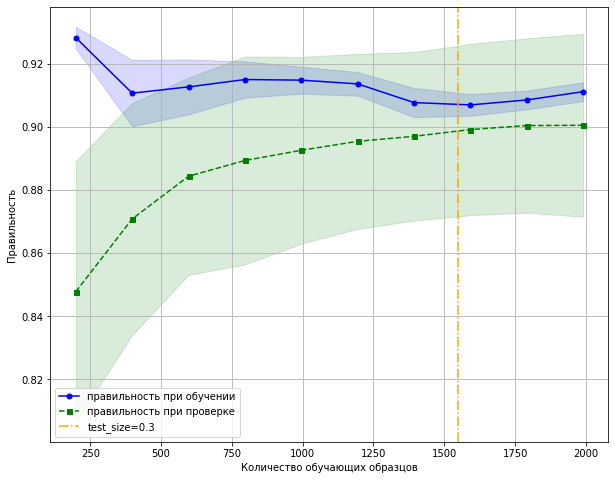

In [27]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

train_sizes, train_scores, test_scores = learning_curve(estimator=base_lr, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='roc_auc', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.7, color='orange', linestyle='-.', label='test_size=0.3')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# setting test_size=0.3 looks fine, but in case of validation data we will set
# test_size=0.25, valid_size=0.1

In [28]:
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')

Train size: 1692, Validation size: 188, Test size: 332


#### Outliers

In [29]:
detector = IsolationForest(n_estimators=100, contamination=0.005, n_jobs=-1, random_state=seed)
out_cols = [column for column in X.columns if column.startswith('Num') or column.startswith('Mnt')]
outliers = detector.fit_predict(X[out_cols])
out_index = X.loc[outliers == -1, out_cols].index
X.loc[outliers == -1, out_cols]

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
21,1,1,1725,1,1,1,15,0,28,0,1
126,450,133,951,173,0,216,1,3,6,6,1
164,20,2,1582,1,2,1,15,0,22,0,0
627,1001,17,572,93,125,17,7,11,11,5,7
646,1009,181,104,202,21,207,0,9,8,13,3
681,1132,134,384,175,134,115,1,11,5,13,7
687,55,16,1622,17,3,4,15,0,28,1,0
855,265,199,303,234,9,170,7,10,2,12,7
1480,265,199,303,234,9,170,7,10,2,12,7
1492,1259,172,815,97,148,33,1,7,11,10,4


In [30]:
# raw predictions
base_lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=5, eval_metric='roc_auc')
base_raw_train = base_lgbm.predict(X_train)
base_raw_test = base_lgbm.predict(X_test)
base_train_proba = base_lgbm.predict_proba(X_train)[:,1]
base_test_proba = base_lgbm.predict_proba(X_test)[:,1]

report(y_train, base_raw_train, y_test, base_raw_test, base_train_proba, base_test_proba)

base_lr.fit(X_train, y_train)
base_raw_train = base_lr.predict(X_train)
base_raw_test = base_lr.predict(X_test)
base_train_proba = base_lr.predict_proba(X_train)[:,1]
base_test_proba = base_lr.predict_proba(X_test)[:,1]

report(y_train, base_raw_train, y_test, base_raw_test, base_train_proba, base_test_proba)

Train
               precision    recall  f1-score   support

           0      0.999     0.955     0.976      1437
           1      0.796     0.992     0.883       255

    accuracy                          0.960      1692
   macro avg      0.897     0.973     0.930      1692
weighted avg      0.968     0.960     0.962      1692

Test
               precision    recall  f1-score   support

           0      0.912     0.918     0.915       282
           1      0.521     0.500     0.510        50

    accuracy                          0.855       332
   macro avg      0.716     0.709     0.713       332
weighted avg      0.853     0.855     0.854       332

Train ROC_AUC: 0.992, Test ROC_AUC: 0.879
Confusion Matrix 
 col_0       0   1
Response         
0         259  23
1          25  25
Train
               precision    recall  f1-score   support

           0      0.964     0.833     0.894      1437
           1      0.467     0.824     0.596       255

    accuracy                 

#### Dropping possible outliers, IQR adjusting and imputing is removed as no significant improve was acheaved

### Feature engeneering, selecting and outlier classes

In [31]:
class FeatureCompose(BaseEstimator, TransformerMixin):
    def __init__(self, weights=np.ones(6)):
        self.weights = weights
        self.weight_vec = pd.Series(data=self.weights, index=['MntWines', 'MntFruits', 'MntMeatProducts',
                                                             'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
                                   name='weights_vector')
        self.age_bin = None
        self.age = None
        self.median_income = None
        self.pipe = None
        self.cols = None
        
    def fit(self, X, y=None):
        X_ = X.dropna().copy()
        #X_['Age'] = 2022 - X_['Year_Birth']
        self.age = X_.groupby(by='Age')['Income'].agg('median').to_dict()
        self.median_income = X_['Income'].median()
        self.pipe = Pipeline(steps=[('scaler', MinMaxScaler()),
                                    ('cluster', KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=seed, tol=1e-04))])
        self.cols = [column for column in X_.columns if column.startswith('Num') or column.startswith('Mnt') or column in ('Income', 'Recency')]
        self.pipe.fit(X_[self.cols])
        del X_
        return self
    
    def transform(self, X):
        # here it is not supposed to deal with 'isoforest' outliers
        X_ = X.copy()
        # Family size
        X_['Family_size'] = X_['Marital_Status']+1 + X_['Kidhome'] + X_['Teenhome']
        # Number of children
        X_['Num_child'] = X_['Kidhome'] + X_['Teenhome']
        # total number of purchases
        num_cols = [col for col in X_.columns if col.startswith('Num')]
        X_['Total_Purch'] = X_[num_cols].sum(axis=1)
        # total amount of spent money, weighted
        mnt_cols = [col for col in X_.columns if col.startswith('Mnt')]
        X_['Total_Mnt'] = (X_[mnt_cols] * self.weight_vec).sum(axis=1)
        # cuts
        X_['Med_age_income'] = X_['Age'].map(self.age)
        X_['Med_age_income'].fillna(self.median_income, inplace=True)
        # cluster distances
        X_[['cluster_0', 'cluster_1']] = self.pipe.transform(X_[self.cols])
        X_ = reduce_memory(X_)
        
        return X_
    
class DataFrameR(BaseEstimator, TransformerMixin):
    def __init__(self, columns, index=None):
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert len(self.columns) == X.shape[1], f'Number of columns {len(self.columns)} is not equal to data shape {X.shape[1]}'
        if self.index is not None:
            X_ = pd.DataFrame(X, columns=self.columns, index=self.index)
        else:
            X_ = pd.DataFrame(X, columns=self.columns)
        return X_
    
class RemoveOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        """Drop possible outliers to further apply IterativeImputer"""
        self.columns = columns
        self.detector = IsolationForest(n_estimators=100, contamination=0.005, n_jobs=-1, random_state=seed)
        
    def fit(self, X, y=None):
        out_cols = [column for column in X.columns if column.startswith('Num') or column.startswith('Mnt')]
        self.detector.fit(X[self.columns])
        return self
    
    def transform(self, X):
        outliers = self.detector.predict(X[self.columns])
        out_index = X[outliers == -1].index
        X.loc[out_index, self.columns] = None
        return X
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, estimator, k_features=12, scoring='f1', test_size=0.2):
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size
        self.estimator = clone(estimator)
        self.fit_params = {}
        if self.estimator.__class__.__name__ == 'LGBMClassifier':
            self.fit_params.update({'verbose': False})

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X, y = X.values, y.values
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y,
                                                            random_state=seed)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X[:, best_indices]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train, **self.fit_params)
        if self.scoring == 'auc':
            y_pred = self.estimator.predict_proba(X_test[:, indices])[:,1]
            score = roc_auc_score(y_test, y_pred)
        elif self.scoring == 'avp':
            y_pred = self.estimator.predict_proba(X_test[:, indices])[:,1]
            score = average_precision_score(y_test, y_pred)
        else:
            y_pred = self.estimator.predict(X_test[:, indices])
            score = f1_score(y_test, y_pred)
        return score

In [32]:
end_columns = ['Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Age', 'Education_2n Cycle', 'Education_Basic',
       'Education_Graduation', 'Education_Master', 'Education_PhD',
       'Family_size', 'Num_child', 'Total_Purch', 'Total_Mnt',
       'Med_age_income', 'cluster_0', 'cluster_1']

### Construct all from the beginning
Next we make simple preprocessing steps, split data and define base pipeline

In [76]:
df = pd.read_csv(path, sep='\t')
df.set_index('ID', inplace=True)
"""Common simple transforms"""
# drop constant
df.drop('Z_CostContact', axis=1, inplace=True)
df.drop('Z_Revenue', axis=1, inplace=True)
# Age
df['Age'] = 2022 - df['Year_Birth']
df.drop('Year_Birth', axis=1, inplace=True)
# days client on 02.04.2022
df["Dt_Customer"] = pd.to_datetime('02-04-2022') - pd.to_datetime(df["Dt_Customer"])
df["Dt_Customer"] = df["Dt_Customer"].dt.days
# outliers
df = df[df['Age'] < 90]
df = df[df['Income'] < 600000]
# status
df['Marital_Status'] = df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", 
                                                     "Absurd":"Single", "Widow":"Single", "YOLO":"Single", 
                                                     "Divorced":"Single", "Single":"Single", "Alone": "Single"})
# map status
df['Marital_Status'] = df['Marital_Status'].map({'Partner': 1, 'Single': 0})
# Education one-hot
df = pd.get_dummies(df, prefix=['Education'])

"""Split"""
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
# columns to drop outliers in pipeline
out_cols = [column for column in df.columns if column.startswith('Num') or column.startswith('Mnt')]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape[0]}, Validation size: {X_valid.shape[0]}, Test size: {X_test.shape[0]}')
# preserve indexes?

Train size: 1692, Validation size: 188, Test size: 332


In [34]:
columns_to_scale = ['Income', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Kidhome', 'Teenhome',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                    'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Med_age_income', 'Family_size', 
                    'Num_child', 'Total_Purch', 'Total_Mnt']
columns_mnt_pca = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
columns_num_pca = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
not_pca = [column for column in end_columns if column not in columns_mnt_pca and column not in columns_num_pca]
not_scale = [column for column in end_columns if column not in columns_to_scale]

In [35]:
N = 0 # number of components to drop in PCA
scaler = Pipeline(steps=[('selector1', ColumnSelector(columns_to_scale)), 
                         ('scaler', MinMaxScaler()), 
                         ('df', DataFrameR(columns_to_scale))])
not_scaler = Pipeline(steps=[('selector2', ColumnSelector(columns=not_scale))])

union = FeatureUnion(transformer_list=[('scale', scaler),
                                       ('not_scale', not_scaler)])

starter_pipe = Pipeline(steps=[('preprocessor', FeatureCompose()),
                               ('union_scaling', union),
                               ('dframer', DataFrameR(columns_to_scale+not_scale)),                     
                              ])
pca_mnt = Pipeline(steps=[('selector_mnt', ColumnSelector(columns_mnt_pca)),
                          ('pca_mnt', PCA(n_components=len(columns_mnt_pca)-N, random_state=seed)),
                          ('framer_mnt', DataFrameR([f"mnt_{i+1}" for i in range(len(columns_mnt_pca)-N)]))])

pca_num = Pipeline(steps=[('selector_num', ColumnSelector(columns_num_pca)),
                          ('pca_mnt', PCA(n_components=len(columns_num_pca)-N, random_state=seed)),
                          ('framer_mnt', DataFrameR([f"num_{i+1}" for i in range(len(columns_num_pca)-N)]))])

union_2 = FeatureUnion(transformer_list=[('select_no_pca', ColumnSelector(not_pca)), 
                                         ('pca_MNT', pca_mnt),
                                         ('pca_NUM', pca_num)])

estimator_boost = LGBMClassifier(verbose=-1, is_unbalance=True, max_depth=3)
estimator = LogisticRegression(class_weight='balanced', random_state=seed, C=1.0)

pipe = Pipeline(steps=[('starter', starter_pipe),
                       #('feature_selector', BestSet(estimator=estimator, k_features=20, scoring='auc')),
                       ('transform', ColumnTransformer([('poly2', PolynomialFeatures(degree=2, interaction_only=True), columns_num_pca+columns_mnt_pca)], 
                                         remainder='passthrough')),                       
                       ('pca', KernelPCA(n_components=len(end_columns)*2-7, random_state=seed)),
                       #('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                       #('union_', union_2), # no improvement
                       #('feature_selector', BestSet(estimator=estimator, k_features=25, scoring='auc')), # not helping
                       ])
pipe_boost = Pipe(steps=[('preprocessor', FeatureCompose()),
                         ('feature_selector', BestSet(estimator=estimator_boost, k_features=25, scoring='auc')),
                         ('smote', SMOTETomek(sampling_strategy=.8, random_state=seed)),
                         ('model', LGBMClassifier(verbose=-1, is_unbalance=True))
                        ])

In [36]:
selector = BorutaShap(model=LGBMClassifier(verbose=-1, is_unbalance=True), importance_measure='shap', classification=True)
selector.fit(X_train, y_train, n_trials=50, sample=False, verbose=False)
# lots of features are decided as unimportant

  0%|          | 0/50 [00:00<?, ?it/s]

```
9 attributes confirmed important: ['AcceptedCmp5', 'AcceptedCmp1', 'Recency', 'Marital_Status', 'NumStorePurchases', 'MntMeatProducts', 'Income', 'AcceptedCmp3', 'Dt_Customer']
25 attributes confirmed unimportant: ['Education_Graduation', 'NumCatalogPurchases', 'Education_PhD', 'Med_age_income', 'MntWines', 'NumDealsPurchases', 'Age', 'MntFruits', 'Complain', 'NumWebVisitsMonth', 'Education_2n Cycle', 'Teenhome', 'Family_size', 'AcceptedCmp2', 'Num_child', 'Total_Mnt', 'AcceptedCmp4', 'cluster_0', 'NumWebPurchases', 'MntGoldProds', 'Kidhome', 'MntFishProducts', 'Education_Basic', 'Education_Master', 'MntSweetProducts']
2 tentative attributes remains: ['cluster_1', 'Total_Purch']
```

In [37]:
remain = ['AcceptedCmp5', 'AcceptedCmp1', 'Recency', 'Marital_Status', 'NumStorePurchases', 'MntMeatProducts', 
          'Income', 'AcceptedCmp3', 'Dt_Customer', 'cluster_1', 'Total_Purch']
#X_train = X_train[remain]
#X_valid = X_valid[remain]
#X_test = X_test[remain]

In [38]:
# for logistic regression
X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.transform(X_test)
smote = SMOTETomek(sampling_strategy=.6, random_state=seed)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [39]:
lr = LogisticRegression(class_weight='balanced', random_state=seed, C=1.)
lr.fit(X_train, y_train)
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
pred_train_proba = lr.predict_proba(X_train)[:,1]
pred_test_proba = lr.predict_proba(X_test)[:,1]

report(y_train, pred_train, y_test, pred_test, pred_train_proba, pred_test_proba)
print(f'Train AVP: {average_precision_score(y_train, pred_train_proba):.3f}')
print(f'Test AVP: {average_precision_score(y_test, pred_test_proba):.3f}')
# with kernel-pca instead of Best set selection we got another results, the bias is even more higher, but FN & FP are better
# a lot of linear correlations that are present in data and noise were eliminated by kernel-pca transformation
# polynomial model overfits

Train
               precision    recall  f1-score   support

           0      0.898     0.840     0.868      1419
           1      0.757     0.839     0.796       844

    accuracy                          0.840      2263
   macro avg      0.827     0.839     0.832      2263
weighted avg      0.845     0.840     0.841      2263

Test
               precision    recall  f1-score   support

           0      0.943     0.887     0.914       282
           1      0.522     0.700     0.598        50

    accuracy                          0.858       332
   macro avg      0.733     0.793     0.756       332
weighted avg      0.880     0.858     0.867       332

Train ROC_AUC: 0.925, Test ROC_AUC: 0.897
Confusion Matrix 
 col_0       0   1
Response         
0         250  32
1          15  35
Train AVP: 0.873
Test AVP: 0.622


In [40]:
# without polynomial
from sklearn.svm import SVC

svc = SVC(C=100.0, kernel='linear', degree=2, gamma='scale', probability=True, class_weight='balanced')
svc.fit(X_train, y_train)
pred_train = svc.predict(X_train)
pred_test = svc.predict(X_test)
pred_train_proba = svc.predict_proba(X_train)[:,1]
pred_test_proba = svc.predict_proba(X_test)[:,1]

report(y_train, pred_train, y_test, pred_test, pred_train_proba, pred_test_proba)
print(f'Train AVP: {average_precision_score(y_train, pred_train_proba):.3f}')
print(f'Test AVP: {average_precision_score(y_test, pred_test_proba):.3f}')
# preprocessing as in lr but without polynomial features which is obvious

Train
               precision    recall  f1-score   support

           0      0.917     0.848     0.881      1419
           1      0.774     0.871     0.819       844

    accuracy                          0.857      2263
   macro avg      0.845     0.860     0.850      2263
weighted avg      0.864     0.857     0.858      2263

Test
               precision    recall  f1-score   support

           0      0.946     0.872     0.908       282
           1      0.500     0.720     0.590        50

    accuracy                          0.849       332
   macro avg      0.723     0.796     0.749       332
weighted avg      0.879     0.849     0.860       332

Train ROC_AUC: 0.934, Test ROC_AUC: 0.884
Confusion Matrix 
 col_0       0   1
Response         
0         246  36
1          14  36
Train AVP: 0.873
Test AVP: 0.609


In [41]:
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=500, max_depth=5, min_samples_split=45, min_samples_leaf=5, 
                              class_weight='balanced', random_state=123)

forest.fit(X_train, y_train)

pred_train = forest.predict(X_train)
pred_test = forest.predict(X_test)
pred_train_proba = forest.predict_proba(X_train)[:,1]
pred_test_proba = forest.predict_proba(X_test)[:,1]

report(y_train, pred_train, y_test, pred_test, pred_train_proba, pred_test_proba)
print(f'Train AVP: {average_precision_score(y_train, pred_train_proba):.3f}')
print(f'Test AVP: {average_precision_score(y_test, pred_test_proba):.3f}')

Train
               precision    recall  f1-score   support

           0      0.875     0.889     0.882      1419
           1      0.808     0.787     0.797       844

    accuracy                          0.851      2263
   macro avg      0.841     0.838     0.839      2263
weighted avg      0.850     0.851     0.850      2263

Test
               precision    recall  f1-score   support

           0      0.925     0.876     0.900       282
           1      0.462     0.600     0.522        50

    accuracy                          0.834       332
   macro avg      0.693     0.738     0.711       332
weighted avg      0.855     0.834     0.843       332

Train ROC_AUC: 0.930, Test ROC_AUC: 0.859
Confusion Matrix 
 col_0       0   1
Response         
0         247  35
1          20  30
Train AVP: 0.898
Test AVP: 0.568


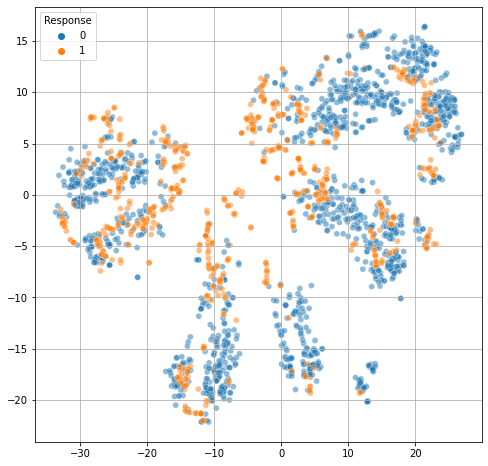

In [42]:
embedding = TSNE(n_components=2, perplexity=150, random_state=123, n_jobs=-1).fit_transform(X_train)

plt.figure(figsize=(8,8))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y_train, data=embedding, alpha=0.5)
plt.grid()
plt.show()
# the data is not "quite" separable

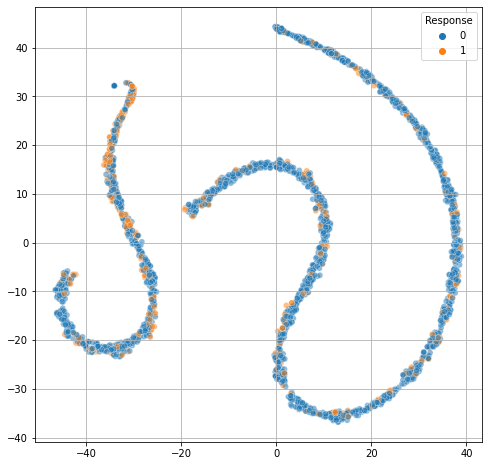

In [43]:
embedding = TSNE(n_components=2, perplexity=50, random_state=123, n_jobs=-1).fit_transform(X)

plt.figure(figsize=(8,8))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y, data=embedding, alpha=0.5)
plt.grid()
plt.show()

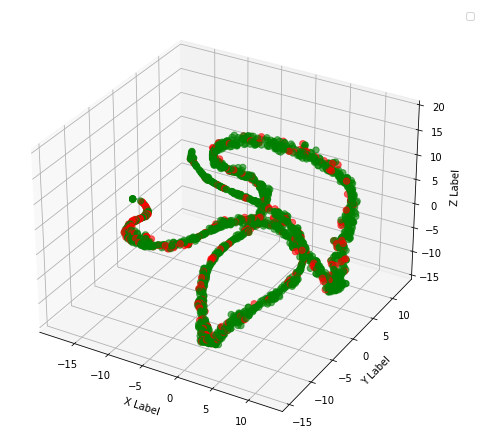

In [44]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

embedding = TSNE(n_components=3, perplexity=50, random_state=123, n_jobs=-1).fit_transform(X)

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c=y.map({0: 'green', 1: 'red'}), s=40, marker='o', alpha=0.6)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### LightGBM model

In [47]:
# redefine datasets first!
X_train, y_train = pipe_boost[:3].fit_resample(X_train, y_train)
X_valid = pipe_boost[:2].transform(X_valid)

In [ ]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123
}
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': False
}

In [ ]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 30, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 80, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    param_trials.update(model_params)
    opt_model = LGBMClassifier(**param_trials)
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=350, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [48]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123,
                'max_depth': 7,
                'learning_rate': 0.4327804963936754,
                'reg_alpha': 4.677471904510624,
                'reg_lambda': 4.046531932784275,
                'num_leaves': 177,
                'subsample': 0.8872682894784513,
                'colsample_bytree': 0.8791931580090088,
                'max_bin': 102,
                'min_child_samples': 236,
                'min_child_weight': 0.0663351899300188,
                'boosting_type': 'gbdt',
}

In [49]:
# get result probabilities on 10 folds
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=10)
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_fold, X_test, y_fold, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
fitted_pipelines = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    pipe_boost = Pipe(steps=[('preprocessor', FeatureCompose()),
                             ('feature_selector', BestSet(estimator=estimator_boost, k_features=28, scoring='auc')),
                             #('Scaler_for_pca', StandardScaler()),
                             #('kernel', KernelPCA(n_components=len(end_columns)-5, kernel='rbf', random_state=seed)),
                             ('smote', SMOTETomek(sampling_strategy=.8, random_state=seed)),
                             ('model', LGBMClassifier(verbose=-1, **model_params))
                            ])
    X_train, y_train = pipe_boost[:3].fit_resample(X_train, y_train)
    X_valid = pipe_boost[:2].transform(X_valid)
    X_test_ = pipe_boost[:2].transform(X_test)
    
    fit_params = {'early_stopping_rounds': 4,  
                  'eval_set': [(X_valid, y_valid)],  
                  'eval_metric': 'auc',
                  'verbose': False
              }

    pipe_boost[-1].fit(X_train, y_train, **fit_params)
    test_labels = pipe_boost[-1].predict(X_test_)
    test_pred.append(test_labels)
    
    train_proba = pipe_boost[-1].predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = pipe_boost[-1].predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = pipe_boost[-1].predict_proba(X_test_)[:,1]
    test_results.append(pred_test)
    print(classification_report(y_test, test_labels, digits=3))
    print(f"{average_precision_score(y_test, pred_test):.3f}")
    print('-'*30)
    fitted_pipelines.append(pipe_boost)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=np.ones(10))

              precision    recall  f1-score   support

           0      0.929     0.907     0.918       376
           1      0.539     0.612     0.573        67

    accuracy                          0.862       443
   macro avg      0.734     0.759     0.746       443
weighted avg      0.870     0.862     0.866       443

0.628
------------------------------
              precision    recall  f1-score   support

           0      0.927     0.912     0.920       376
           1      0.548     0.597     0.571        67

    accuracy                          0.865       443
   macro avg      0.737     0.755     0.745       443
weighted avg      0.870     0.865     0.867       443

0.585
------------------------------
              precision    recall  f1-score   support

           0      0.918     0.923     0.920       376
           1      0.554     0.537     0.545        67

    accuracy                          0.865       443
   macro avg      0.736     0.730     0.733       443


In [50]:
model = fitted_pipelines[1]  # select best model
X_fold_ = model[:2].transform(X_fold)
X_test_ = model[:2].transform(X_test)

In [51]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')
# model overfitted - high variance

train mean accuracy: 0.9267, test accuracy: 0.8736
train mean f1: 0.9173, test f1: 0.5625
train mean auc: 0.9801, test auc: 0.8918


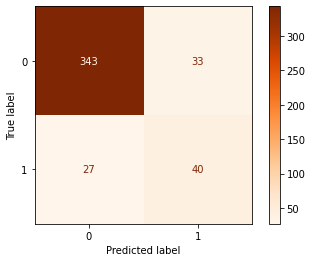

In [52]:
ConfusionMatrixDisplay.from_estimator(model[-1], X_test_, y_test, cmap='Oranges')
plt.show()

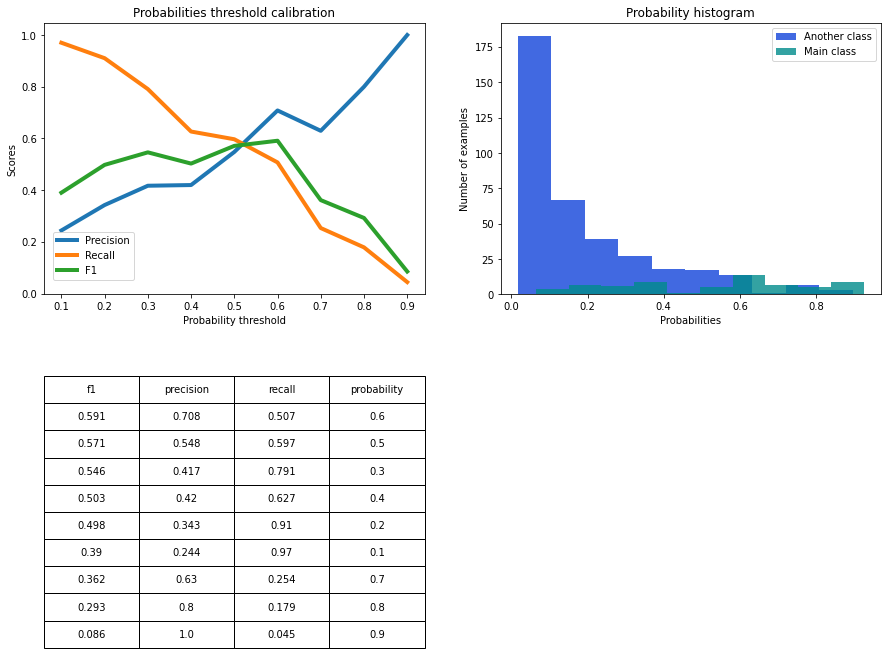

In [53]:
show_proba_calibration_plots(model[-1].predict_proba(X_test_)[:,1], y_test)
# no calibration needed

In [54]:
test_probs = model[-1].predict_proba(X_test_)[:,1]
test_labels = model[-1].predict(X_test_)

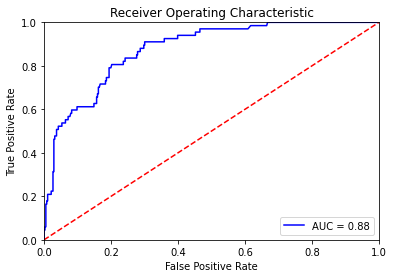

In [55]:
roc_plot(y_test, test_probs)

In [56]:
X_ = pipe_boost[0].fit_transform(X_fold)
X_ = X_.iloc[:, list(pipe_boost[1].subsets_[np.argmax(pipe_boost[1].scores_)])]

In [57]:
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold(threshold=1000)
var_selected = var.fit_transform(X_)
var.get_feature_names_out()
print('High variance features:')
print('-'*30)
for x, vr in zip(X_.columns, var.get_support()):
    if vr:
        print(f'{x}')

High variance features:
------------------------------
Income
Dt_Customer
MntWines
MntFruits
MntMeatProducts
MntFishProducts
MntSweetProducts
MntGoldProds
Med_age_income


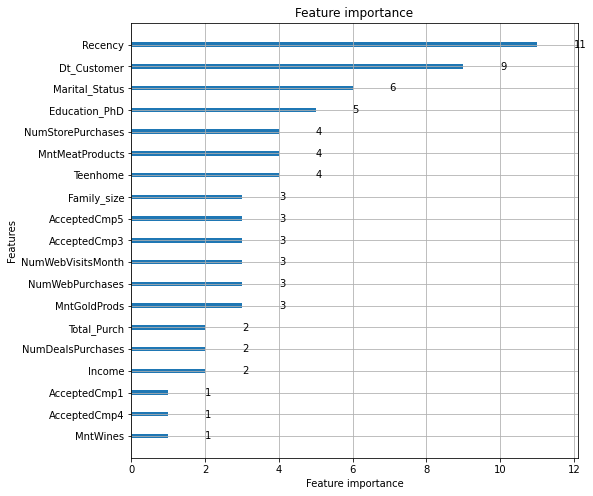

In [58]:
import lightgbm

fig, ax = plt.subplots(1, 1, figsize=(8,8))
lightgbm.plot_importance(pipe_boost[-1], ax=ax)
ax.set_yticklabels(X_.columns[[4,3,0,22,13,7,2,23,17,15,14,12,10,25,11,1,18,16,5]][::-1])
plt.show()

#### with pca decomposition
```
train mean accuracy: 0.8884, test accuracy: 0.8533
train mean f1: 0.8773, test f1: 0.5806
train mean auc: 0.9565, test auc: 0.8842
```

In [59]:
print(classification_report(y_test, test_labels, digits=3))

              precision    recall  f1-score   support

           0      0.927     0.912     0.920       376
           1      0.548     0.597     0.571        67

    accuracy                          0.865       443
   macro avg      0.737     0.755     0.745       443
weighted avg      0.870     0.865     0.867       443



### Observe shap values

In [60]:
explainer = shap.TreeExplainer(pipe_boost[-1])

data = pd.Series(data=X_.iloc[np.random.randint(len(X_)), :].values, index=X_.columns.tolist())
# Calculate Shap values
shap_values = explainer.shap_values(data.values.reshape(1,-1))

In [61]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data)

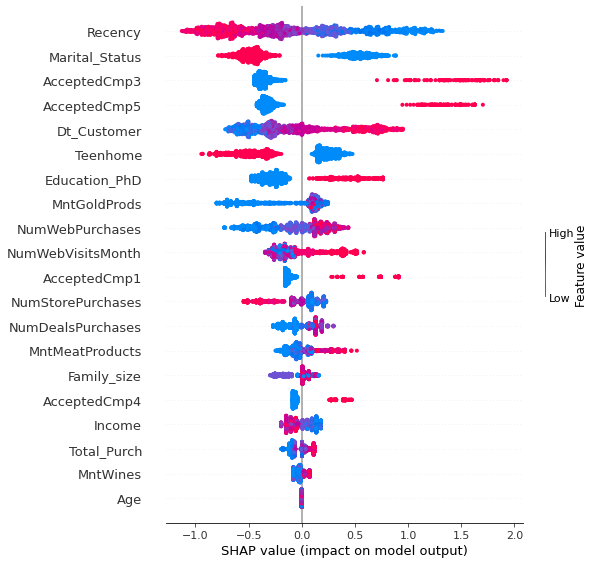

In [62]:
shap.initjs()

shap_values = explainer.shap_values(X_)
shap.summary_plot(shap_values[1], X_)

In [63]:
def plot_ROC(y_train_true, y_train_prob, y_test_true, y_test_prob):
    '''
    a funciton to plot the ROC curve for train labels and test labels.
    Use the best threshold found in train set to classify items in test set.
    '''
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_true, y_train_prob, pos_label=True)
    sum_sensitivity_specificity_train = tpr_train + (1-fpr_train)
    best_threshold_id_train = np.argmax(sum_sensitivity_specificity_train)
    best_threshold = thresholds_train[best_threshold_id_train]
    best_fpr_train = fpr_train[best_threshold_id_train]
    best_tpr_train = tpr_train[best_threshold_id_train]
    y_train = y_train_prob > best_threshold

    cm_train = confusion_matrix(y_train_true, y_train)
    acc_train = accuracy_score(y_train_true, y_train)
    auc_train = roc_auc_score(y_train_true, y_train)

    print('Train Accuracy: %s ' %acc_train)
    print('Train AUC: %s ' %auc_train)
    print('Train Confusion Matrix:')
    print(cm_train)

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    curve1 = ax.plot(fpr_train, tpr_train)
    curve2 = ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax.plot(best_fpr_train, best_tpr_train, marker='o', color='black')
    ax.text(best_fpr_train, best_tpr_train, s = '(%.3f,%.3f)' %(best_fpr_train, best_tpr_train))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Train), AUC = %.4f'%auc_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_true, y_test_prob, pos_label =True)

    y_test = y_test_prob > best_threshold

    cm_test = confusion_matrix(y_test_true, y_test)
    acc_test = accuracy_score(y_test_true, y_test)
    auc_test = roc_auc_score(y_test_true, y_test)

    print('Test Accuracy: %s ' %acc_test)
    print('Test AUC: %s ' %auc_test)
    print('Test Confusion Matrix:')
    print(cm_test)

    tpr_score = float(cm_test[1][1])/(cm_test[1][1] + cm_test[1][0])
    fpr_score = float(cm_test[0][1])/(cm_test[0][0]+ cm_test[0][1])

    ax2 = fig.add_subplot(122)
    curve1 = ax2.plot(fpr_test, tpr_test)
    curve2 = ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
    dot = ax2.plot(fpr_score, tpr_score, marker='o', color='black')
    ax2.text(fpr_score, tpr_score, s = '(%.3f,%.3f)' %(fpr_score, tpr_score))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (Test), AUC = %.4f'%auc_test)
    plt.savefig('ROC', dpi = 500)
    plt.show()

    return best_threshold

Train Accuracy: 0.8773318258903335 
Train AUC: 0.8411772945337396 
Train Confusion Matrix:
[[1342  161]
 [  56  210]]
Test Accuracy: 0.837471783295711 
Test AUC: 0.7447999364877739 
Test Confusion Matrix:
[[330  46]
 [ 26  41]]


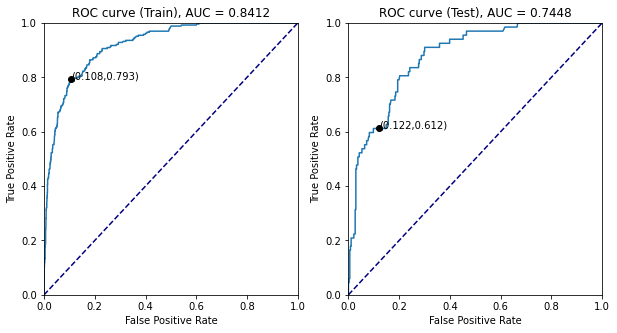

0.4358516041511688

In [64]:
plot_ROC(y_fold, model[-1].predict_proba(X_fold_)[:,1], y_test, test_probs)
# best threshold that may separate classes better is 0.41

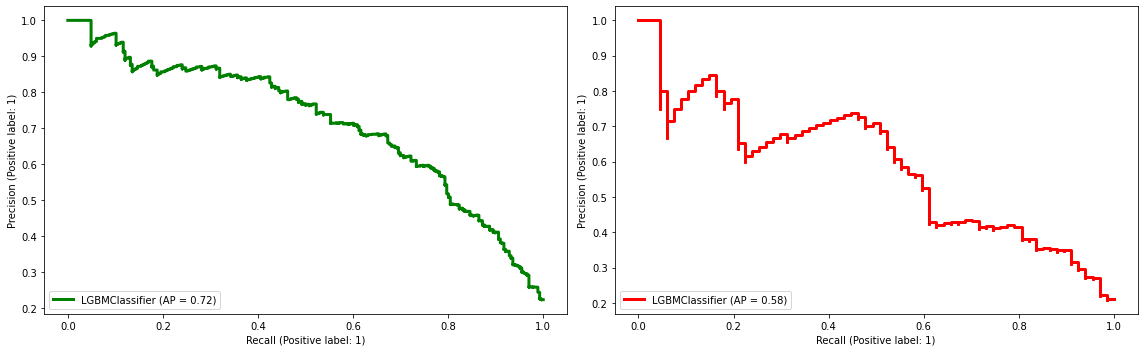

In [65]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax = ax.flatten()
PrecisionRecallDisplay.from_estimator(model[-1], X_fold_, y_fold, color='green', lw=3, ax=ax[0])
PrecisionRecallDisplay.from_estimator(model[-1], X_test_, y_test, color='red', lw=3, ax=ax[1])
plt.tight_layout()
plt.show()
# this plots displays that our model is pretty weak 

In [66]:
train_probas = model[-1].predict_proba(X_fold_)[:,1]

for line in ['micro', 'samples', 'weighted', 'macro']:
    print(f"Train Average precision score_{line}: {average_precision_score(y_fold, train_probas, average=line):.4f}")
    print(f"Test Average precision score_{line}: {average_precision_score(y_test, test_probs, average=line):.4f}")
    print('-'*30)

Train Average precision score_micro: 0.7161
Test Average precision score_micro: 0.5850
------------------------------
Train Average precision score_samples: 0.7161
Test Average precision score_samples: 0.5850
------------------------------
Train Average precision score_weighted: 0.7161
Test Average precision score_weighted: 0.5850
------------------------------
Train Average precision score_macro: 0.7161
Test Average precision score_macro: 0.5850
------------------------------


In [ ]:
lightgbm.plot_tree(model[-1], dpi=120, figsize=(8,8), orientation='vertical')
plt.show()

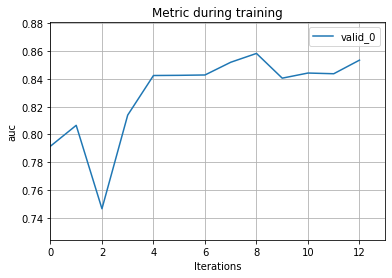

In [69]:
lightgbm.plot_metric(model[-1], metric='auc')
plt.show()

### Some thoughts: Logistic Regeression with KernelPCA showed better results than stratified LGBM model. One reason maybe is that the number of samples is too low

#### While fine-tuning hyperparameters with optuna we may not use over-sampling, but apply average precision metric wich rates model performance with respect to class imbalance

### PS

In [73]:
# restart init preprocessing cell first

pipe_boost = Pipe(steps=[('preprocessor', FeatureCompose()),
                         ('feature_selector', BestSet(estimator=estimator_boost, k_features=25, scoring='avp')),
                         ('smote', SMOTETomek(sampling_strategy=.85, random_state=seed)),
                         ('model', LGBMClassifier(verbose=-1, is_unbalance=True))
                        ])

In [74]:
def avp_metric(y_true, y_pred):
    avp = average_precision_score(y_true, y_pred)
    return 'avp_score', avp, True

In [77]:
X_train, y_train = pipe_boost[:3].fit_resample(X_train, y_train)
X_valid = pipe_boost[:2].transform(X_valid)
X_test = pipe_boost[:2].transform(X_test)

In [83]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123
}
fit_params = {'early_stopping_rounds': 10,  
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': avp_metric,
              'verbose': False
}

In [84]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 265),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 30, 260),
                    'min_child_samples': trial.suggest_int('min_child_samples', 80, 260),
                    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['goss', 'gbdt']),
                    }
    param_trials.update(model_params)
    opt_model = LGBMClassifier(**param_trials)
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = average_precision_score(y_valid, y_pred)
    
    return score

In [85]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=350, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [78]:
model_params = {
                'objective': 'binary', # cross_entropy
                'n_estimators': 800,
                'n_jobs': -1,
                'is_unbalance': True,
                'random_state': 123,
                'max_depth': 6,
                'learning_rate': 0.3179494501546467,
                'reg_alpha': 1.4008744482073932,
                'reg_lambda': 2.9540922582602596,
                'num_leaves': 80,
                'subsample': 0.4058506622653789,
                'colsample_bytree': 0.47567996962383685,
                'max_bin': 113,
                'min_child_samples': 113,
                'min_child_weight': 0.09162381437404929,
                'boosting_type': 'goss',
}

In [79]:
clf = LGBMClassifier(verbose=-1, **model_params)
clf.fit(X_train, y_train, **fit_params)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_train_probs = clf.predict_proba(X_train)[:,1]
y_test_probs = clf.predict_proba(X_test)[:,1]

report(y_train, y_pred_train, y_test, y_pred_test, y_train_probs, y_test_probs)
print(f'Train AVP: {average_precision_score(y_train, y_train_probs):.3f}')
print(f'Test AVP: {average_precision_score(y_test, y_test_probs):.3f}')

Train
               precision    recall  f1-score   support

           0      0.750     0.966     0.844      1365
           1      0.939     0.617     0.745      1149

    accuracy                          0.807      2514
   macro avg      0.844     0.792     0.795      2514
weighted avg      0.836     0.807     0.799      2514

Test
               precision    recall  f1-score   support

           0      0.869     0.961     0.912       282
           1      0.450     0.180     0.257        50

    accuracy                          0.843       332
   macro avg      0.659     0.570     0.585       332
weighted avg      0.806     0.843     0.814       332

Train ROC_AUC: 0.903, Test ROC_AUC: 0.803
Confusion Matrix 
 col_0       0   1
Response         
0         271  11
1          41   9
Train AVP: 0.879
Test AVP: 0.364


In [80]:
test_results, train_roc, test_pred, train_f1, train_acc = [], [], [], [], []
skf = StratifiedKFold(n_splits=10)
X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]
X_fold, X_test, y_fold, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)
fitted_pipelines = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train, X_valid = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train, y_valid = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    pipe_boost = Pipe(steps=[('preprocessor', FeatureCompose()),
                             ('feature_selector', BestSet(estimator=estimator_boost, k_features=25, scoring='avp')),
                             ('smote', SMOTETomek(sampling_strategy=.85, random_state=seed)),
                             ('model', LGBMClassifier(verbose=-1, **model_params))
                            ])
    X_train, y_train = pipe_boost[:3].fit_resample(X_train, y_train)
    X_valid = pipe_boost[:2].transform(X_valid)
    X_test_ = pipe_boost[:2].transform(X_test)
    
    fit_params = {'early_stopping_rounds': 3,  
                  'eval_set': [(X_valid, y_valid)],  
                  'eval_metric': avp_metric,
                  'verbose': False
              }

    pipe_boost[-1].fit(X_train, y_train, **fit_params)
    test_labels = pipe_boost[-1].predict(X_test_)
    test_pred.append(test_labels)
    
    train_proba = pipe_boost[-1].predict_proba(X_train)[:,1]
    train_roc.append(roc_auc_score(y_train, train_proba))
    
    train_labels = pipe_boost[-1].predict(X_train)
    train_f1.append(f1_score(y_train, train_labels))
    train_acc.append(accuracy_score(y_train, train_labels))
    
    pred_test = pipe_boost[-1].predict_proba(X_test_)[:,1]
    test_results.append(pred_test)
    print(classification_report(y_test, test_labels, digits=3))
    print(f"{average_precision_score(y_test, pred_test):.3f}")
    print('-'*30)
    fitted_pipelines.append(pipe_boost)

final_test = np.array(test_results).mean(axis=0)
test_pred = vote(test_pred, weights=np.ones(10))

              precision    recall  f1-score   support

           0      0.914     0.902     0.908       376
           1      0.486     0.522     0.504        67

    accuracy                          0.844       443
   macro avg      0.700     0.712     0.706       443
weighted avg      0.849     0.844     0.847       443

0.542
------------------------------
              precision    recall  f1-score   support

           0      0.926     0.904     0.915       376
           1      0.526     0.597     0.559        67

    accuracy                          0.858       443
   macro avg      0.726     0.751     0.737       443
weighted avg      0.866     0.858     0.861       443

0.587
------------------------------
              precision    recall  f1-score   support

           0      0.908     0.894     0.901       376
           1      0.452     0.493     0.471        67

    accuracy                          0.833       443
   macro avg      0.680     0.693     0.686       443


In [81]:
print(f'train mean accuracy: {np.array(train_acc).mean():.4f}, test accuracy: {accuracy_score(y_test, test_pred):.4f}')
print(f'train mean f1: {np.array(train_f1).mean():.4f}, test f1: {f1_score(y_test, test_pred):.4f}')
print(f'train mean auc: {np.array(train_roc).mean():.4f}, test auc: {roc_auc_score(y_test, final_test):.4f}')

train mean accuracy: 0.9087, test accuracy: 0.8668
train mean f1: 0.9001, test f1: 0.5280
train mean auc: 0.9693, test auc: 0.8820
